Student : Charles AUGUSTE <br>
Master : MVA <br>
mail : charles.auguste@ponts.org <br>


At the end of each part I included comments on the results I got.

### Teacher's initial code

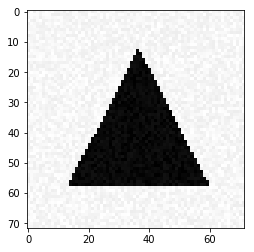

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



# Part 3 Simple classification

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras import utils
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [3]:
# We create the dataaset
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


### Stochastic gradient optimizer

In [4]:
# We compute our first model with a stochastic gradient optimizer
model = Sequential()
model.add(Dense(3, input_dim=X_train.shape[1]))
model.add(Activation('softmax'))
model.compile(optimizer=optimizers.SGD(lr=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# We print the accuracy and include some validation to make sure we are not overfitting 
# even though the question does not require it
model.fit(X_train, utils.to_categorical(Y_train), epochs=100, validation_split=0.1)

Train on 270 samples, validate on 30 samples
Epoch 1/100
270/270 [==============================] - 0s 409us/step - loss: 4.6237 - acc: 0.3370 - val_loss: 3.5875 - val_acc: 0.3000
Epoch 2/100
270/270 [==============================] - 0s 51us/step - loss: 3.9767 - acc: 0.4037 - val_loss: 4.8185 - val_acc: 0.5333
Epoch 3/100
270/270 [==============================] - 0s 50us/step - loss: 4.3736 - acc: 0.3852 - val_loss: 3.7351 - val_acc: 0.5333
Epoch 4/100
270/270 [==============================] - 0s 52us/step - loss: 3.7904 - acc: 0.4333 - val_loss: 4.1731 - val_acc: 0.5333
Epoch 5/100
270/270 [==============================] - 0s 50us/step - loss: 2.8937 - acc: 0.4481 - val_loss: 4.4693 - val_acc: 0.3333
Epoch 6/100
270/270 [==============================] - 0s 48us/step - loss: 2.9449 - acc: 0.5259 - val_loss: 4.5375 - val_acc: 0.3000
Epoch 7/100
270/270 [==============================] - 0s 44us/step - loss: 1.8535 - acc: 0.6111 - val_loss: 0.6063 - val_acc: 0.6333
Epoch 8/100
270/

270/270 [==============================] - 0s 41us/step - loss: 0.3762 - acc: 0.8667 - val_loss: 0.0804 - val_acc: 0.9667
Epoch 62/100
270/270 [==============================] - 0s 41us/step - loss: 0.0627 - acc: 0.9926 - val_loss: 0.0872 - val_acc: 0.9667
Epoch 63/100
270/270 [==============================] - 0s 39us/step - loss: 0.0603 - acc: 0.9963 - val_loss: 0.0720 - val_acc: 0.9667
Epoch 64/100
270/270 [==============================] - 0s 40us/step - loss: 0.1742 - acc: 0.9296 - val_loss: 0.0771 - val_acc: 0.9667
Epoch 65/100
270/270 [==============================] - 0s 44us/step - loss: 0.0857 - acc: 0.9815 - val_loss: 0.0667 - val_acc: 1.0000
Epoch 66/100
270/270 [==============================] - 0s 46us/step - loss: 0.0587 - acc: 0.9926 - val_loss: 0.0940 - val_acc: 1.0000
Epoch 67/100
270/270 [==============================] - 0s 41us/step - loss: 0.0706 - acc: 0.9889 - val_loss: 0.0616 - val_acc: 1.0000
Epoch 68/100
270/270 [==============================] - 0s 40us/step

From the teacher's code, category 0 is a rectangle, category 1 i a disk, and category 2 is a triangle. We check that our first model predicts well.

In [5]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

In [6]:
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[1., 0., 0.]], dtype=float32)

In [7]:
X_test, _ = generate_a_triangle()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 0., 1.]], dtype=float32)

### Adam optimizer

In [8]:
# We compute our first model with the Adam optimizer
model = Sequential()
model.add(Dense(3, input_dim=X_train.shape[1]))
model.add(Activation('softmax'))
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, utils.to_categorical(Y_train), epochs=50, validation_split=0.1, batch_size = 32)

Train on 270 samples, validate on 30 samples
Epoch 1/50
270/270 [==============================] - 0s 350us/step - loss: 1.9702 - acc: 0.3963 - val_loss: 0.8589 - val_acc: 0.5000
Epoch 2/50
270/270 [==============================] - 0s 52us/step - loss: 0.9528 - acc: 0.4963 - val_loss: 0.6870 - val_acc: 0.7667
Epoch 3/50
270/270 [==============================] - 0s 50us/step - loss: 0.7755 - acc: 0.6852 - val_loss: 0.6155 - val_acc: 0.7000
Epoch 4/50
270/270 [==============================] - 0s 70us/step - loss: 0.5700 - acc: 0.6778 - val_loss: 0.3775 - val_acc: 0.8667
Epoch 5/50
270/270 [==============================] - 0s 63us/step - loss: 0.3840 - acc: 0.9037 - val_loss: 0.3323 - val_acc: 0.9667
Epoch 6/50
270/270 [==============================] - 0s 72us/step - loss: 0.3480 - acc: 0.9148 - val_loss: 0.3774 - val_acc: 0.7667
Epoch 7/50
270/270 [==============================] - 0s 57us/step - loss: 0.3220 - acc: 0.8593 - val_loss: 0.2659 - val_acc: 0.9667
Epoch 8/50
270/270 [===

In [9]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

In [10]:
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[1., 0., 0.]], dtype=float32)

In [11]:
X_test, _ = generate_a_triangle()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 0., 1.]], dtype=float32)

### Comments on the results

Both optimizer work very well for this problem, and are able to classify the shapes. Adam seems better that the stochastic gradient though. 
Indeed, I don't have to parametrize it to make it work. And it seems more accurate and requires less epochs to converge (even though that might be because my hyperparameters of SGD are not that good).

# Part 4 Visualization of the solution

In [12]:
weights = model.get_weights()[0]

### Column 0

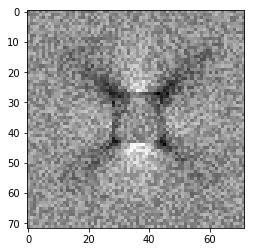

In [13]:
plt.imshow(weights[:,0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

### Column 1

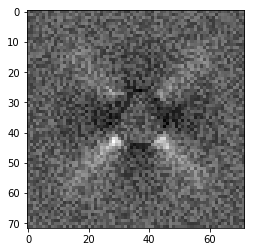

In [14]:
plt.imshow(weights[:,1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

### Column 2

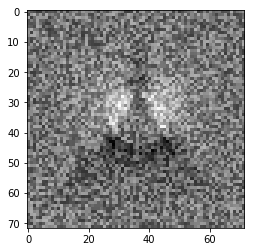

In [15]:
plt.imshow(weights[:,2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

### Comments on the results

The 3 columns correspont to our 3 classes. We can see that our network detects a rectangle by finding its corners (hence the black area around the corners), detects a circle by not finding corners (hence the white areas where the corners should be), and detects a triangle by not finding colored pixels at the top of the image, but by finding some on its bottom).

# Part 5 A More Difficult Classification Problem

In [16]:
from keras.layers import Conv2D, MaxPooling2D, Flatten

In [17]:
# We generate the trainign set
[X_train, Y_train] = generate_dataset_classification(3000, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

In [18]:
# We generate a test set
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


### Same linear classifier

In [19]:
# We retrain the same model as before
model = Sequential()
model.add(Dense(3, input_dim=X_train.shape[1]))
model.add(Activation('softmax'))
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, utils.to_categorical(Y_train), epochs=50, batch_size = 32)

Epoch 1/50
3000/3000 [==============================] - 0s 64us/step - loss: 1.3445 - acc: 0.4570
Epoch 2/50
3000/3000 [==============================] - 0s 37us/step - loss: 0.9816 - acc: 0.5310
Epoch 3/50
3000/3000 [==============================] - 0s 38us/step - loss: 0.8422 - acc: 0.5727
Epoch 4/50
3000/3000 [==============================] - 0s 37us/step - loss: 0.8474 - acc: 0.5983
Epoch 5/50
3000/3000 [==============================] - 0s 37us/step - loss: 1.0264 - acc: 0.5753
Epoch 6/50
3000/3000 [==============================] - 0s 37us/step - loss: 0.8775 - acc: 0.5820
Epoch 7/50
3000/3000 [==============================] - 0s 37us/step - loss: 0.8966 - acc: 0.5867
Epoch 8/50
3000/3000 [==============================] - 0s 37us/step - loss: 0.8823 - acc: 0.5763
Epoch 9/50
3000/3000 [==============================] - 0s 37us/step - loss: 0.8582 - acc: 0.5987
Epoch 10/50
3000/3000 [==============================] - 0s 38us/step - loss: 0.8241 - acc: 0.6137
Epoch 11/50
3000/30

In [20]:
"Loss : {}, Accuracy : {}".format(*model.evaluate(X_test, Y_test))

300/300 [==============================] - 0s 90us/step


'Loss : 0.7278831521670024, Accuracy : 0.6233333341280619'

We see that our simple classifier overfitted on the trainign data, because our accuracy is much lower on the test set, and our loss is much higher.

### Convolutional "deep" network

In [21]:
# We need to reshape our data to be able to use it in our model
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

In [22]:
model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, utils.to_categorical(Y_train), epochs=10, batch_size=32)

Epoch 1/10
3000/3000 [==============================] - 4s 1ms/step - loss: 0.8492 - acc: 0.6440
Epoch 2/10
3000/3000 [==============================] - 3s 1ms/step - loss: 0.5811 - acc: 0.7667
Epoch 3/10
3000/3000 [==============================] - 3s 1ms/step - loss: 0.4850 - acc: 0.8317
Epoch 4/10
3000/3000 [==============================] - 3s 971us/step - loss: 0.3848 - acc: 0.8750
Epoch 5/10
3000/3000 [==============================] - 3s 892us/step - loss: 0.3373 - acc: 0.8940
Epoch 6/10
3000/3000 [==============================] - 3s 910us/step - loss: 0.2672 - acc: 0.9210
Epoch 7/10
3000/3000 [==============================] - 3s 931us/step - loss: 0.2385 - acc: 0.9303
Epoch 8/10
3000/3000 [==============================] - 3s 915us/step - loss: 0.2150 - acc: 0.9417
Epoch 9/10
3000/3000 [==============================] - 3s 918us/step - loss: 0.1715 - acc: 0.9560
Epoch 10/10
3000/3000 [==============================] - 3s 917us/step - loss: 0.1456 - acc: 0.9593


In [23]:
"Loss : {}, Accuracy : {}".format(*model.evaluate(X_test, Y_test))

300/300 [==============================] - 0s 532us/step


'Loss : 0.21045008500417073, Accuracy : 0.9433333325386047'

### Comments on the results

Our original classifier does not perform very well on this problem with a validation accuracy a bit above 60%. Indeed, it is not general enough to be able to solve the problem. Moreover, it tends to overfit. Here, we used 3000 samples as a training input, so there is only a slight overfit. But with 300 input images, the overfit would be much bigger. We can see that there is an overfit because the loss is bigger, and the accuracy is smaller. 


Regarding the convolutional network, it performs quite well on this problem, because the convolutional network allows it to detect patterns on the image. We get a validation accuracy of about 90% which is quite good. However, it seems that it also tends to overfit a bit. Indeed, the loss is higher for the validation than for the training, and the accuracy is a bit lower. Still, these results seem quite satisfying.

# Part 6 A Regression Problem

In [200]:
#We create a training set
[X_train, Y_train] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [79]:
#We generate the test set
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [204]:
# We need to reshape our data to be able to use it in our model
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

In [81]:
#Y_test = (Y_test - Y_train.mean()) / Y_train.std()
#Y_train = (Y_train - Y_train.mean()) / Y_train.std()

In [177]:
model = Sequential()
model.add(Conv2D(1, (4, 4), activation='relu'))
model.add(Conv2D(3, (4, 4), activation='relu'))
model.add(Flatten())
model.add(Dense(6))
model.compile(optimizer="adam",
              loss='mse')

model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split = 0.02)

Train on 2940 samples, validate on 60 samples
Epoch 1/10
2940/2940 [==============================] - 4s 1ms/step - loss: 0.1010 - val_loss: 0.0762
Epoch 2/10
2940/2940 [==============================] - 3s 1ms/step - loss: 0.0680 - val_loss: 0.0547
Epoch 3/10
2940/2940 [==============================] - 3s 905us/step - loss: 0.0559 - val_loss: 0.0552
Epoch 4/10
2940/2940 [==============================] - 2s 798us/step - loss: 0.0494 - val_loss: 0.0569
Epoch 5/10
2940/2940 [==============================] - 2s 800us/step - loss: 0.0428 - val_loss: 0.0601
Epoch 6/10
2940/2940 [==============================] - 2s 833us/step - loss: 0.0365 - val_loss: 0.0627
Epoch 7/10
2940/2940 [==============================] - 3s 908us/step - loss: 0.0308 - val_loss: 0.0673
Epoch 8/10
2940/2940 [==============================] - 3s 902us/step - loss: 0.0258 - val_loss: 0.0707
Epoch 9/10
2940/2940 [==============================] - 3s 899us/step - loss: 0.0220 - val_loss: 0.0747
Epoch 10/10
2940/2940 

In [178]:
"Loss : {}, Accuracy : {}".format(*model.evaluate(X_test, Y_test))

300/300 [==============================] - 0s 521us/step


TypeError: format() argument after * must be an iterable, not numpy.float64

In [179]:
Y_predict = model.predict(X_test)

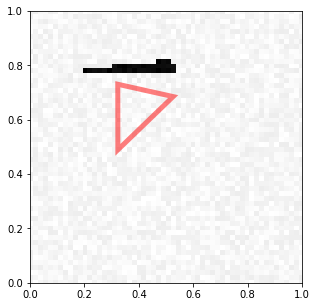

In [180]:
# We visualize an image
visualize_prediction(X_test[1], Y_predict[1])

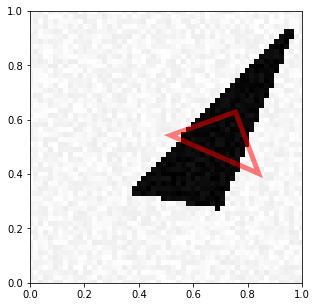

In [181]:
# We visualize an image
visualize_prediction(X_test[0], Y_predict[0])

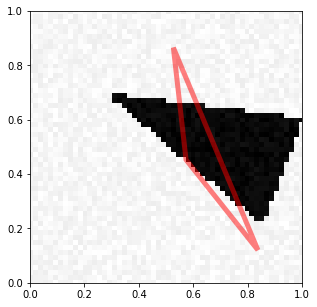

In [182]:
# We visualize an image
visualize_prediction(X_test[10], Y_predict[10])

In [183]:
Y_predictt = model.predict(X_train)

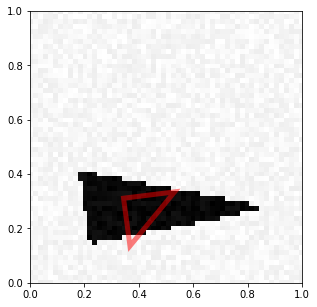

In [184]:
# We visualize an image
visualize_prediction(X_train[10], Y_predictt[10])

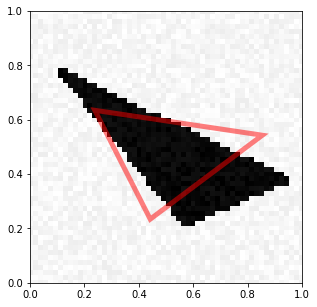

In [185]:
# We visualize an image
visualize_prediction(X_train[0], Y_predictt[0])

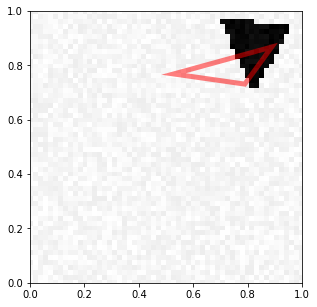

In [186]:
# We visualize an image
visualize_prediction(X_train[1], Y_predictt[1])

In [190]:
Y_train * IMAGE_SIZE 

array([[ 532.5088967 , 4023.05862773, 2871.56932605, 1085.34407062,
        4823.62939352, 1936.71763195],
       [4172.04942518, 3741.02903186, 4806.61327402, 4904.15227471,
        3607.6305793 , 5002.26760594],
       [2207.53068819, 1863.32285501, 2367.1716385 , 4234.93494134,
        3508.97687699, 3595.10122152],
       ...,
       [4808.3219158 ,  540.24225546, 4525.84632253, 1309.48300301,
          55.66597921, 3530.19657301],
       [ 485.85747406, 4496.72320966, 3287.8571334 ,  990.00463223,
          53.49089217, 4757.65558056],
       [4480.15952573, 2382.4845815 , 4647.90907799, 4643.87651135,
        3315.9057539 , 2899.74739436]])

In [205]:
X = np.zeros(X_train.shape)
for y in Y_train:
    a,b,c,d,e,f = y
    X[int(a), int(b)] = 1.
    X[int(c), int(d)] = 1.
    X[int(e), int(f)] = 1.

In [206]:
model = Sequential()
model.add(Conv2D(1, (4, 4), activation='relu'))
model.add(Conv2D(3, (4, 4), activation='relu'))
model.add(Flatten())
model.add(Dense(5184))
model.compile(optimizer="adam",
              loss='mse')

model.fit(X_train, X.reshape(300, -1), epochs=10, batch_size=32, validation_split = 0.02)

Train on 294 samples, validate on 6 samples
Epoch 1/10
294/294 [==============================] - 8s 28ms/step - loss: 0.2413 - val_loss: 0.0858
Epoch 2/10
294/294 [==============================] - 6s 20ms/step - loss: 0.0387 - val_loss: 0.0027
Epoch 3/10
294/294 [==============================] - 6s 19ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 4/10
294/294 [==============================] - 6s 19ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 5/10
294/294 [==============================] - 6s 20ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 6/10
294/294 [==============================] - 6s 20ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 7/10
294/294 [==============================] - 6s 20ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 8/10
294/294 [==============================] - 6s 20ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 9/10
294/294 [==============================] - 6s 20ms/step - loss: 9.4680e-04 - val_loss: 0.0013
Epoch 10/10
294/294 [======================

In [210]:
model.predict(X_train)[0].max()

0.060068518

# 7 Image Denoising

In [160]:
def generate_a_rectangle_modified(free_location=True):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return np.array([generate_a_drawing(figsize, U, V, 700.), generate_a_drawing(figsize, U, V, 0.0)])

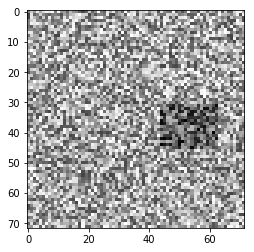

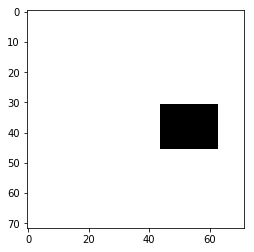

In [161]:
imNoisy, imNormal = generate_a_rectangle_modified()
plt.imshow(imNoisy.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
plt.imshow(imNormal.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

In [162]:
data_train = np.array([generate_a_rectangle_modified() for i in range(300)])
data_test = np.array([generate_a_rectangle_modified() for i in range(10)])

In [163]:
X_train = data_train[:,0,:]
Y_train = data_train[:,1,:]

X_test = data_test[:,0,:]
Y_test = data_test[:,1,:]

In [164]:
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

Y_train = Y_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
Y_test = Y_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

In [165]:
from keras.layers import Conv2DTranspose
from keras.layers import UpSampling2D

model = Sequential()
model.add(Conv2D(16, (4, 4), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (4, 4), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(UpSampling2D(size=(2, 2)))
model.add(Conv2DTranspose(10, (5, 5), activation = "relu", padding = 'same'))
model.add(UpSampling2D(size=(2, 2)))
model.add(Conv2DTranspose(10, (5, 5), activation = "relu", padding = 'same'))
model.add(Dense(1))
model.compile(optimizer="adam",
              loss='mse')

# We use some kind of validation because it is easier to see if we overfit accross iterations
model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split = 0.1)

Train on 270 samples, validate on 30 samples
Epoch 1/100
270/270 [==============================] - 2s 9ms/step - loss: 15154.5375 - val_loss: 9348.2129
Epoch 2/100
270/270 [==============================] - 1s 5ms/step - loss: 6538.4787 - val_loss: 4263.2471
Epoch 3/100
270/270 [==============================] - 1s 5ms/step - loss: 4898.3839 - val_loss: 3109.3752
Epoch 4/100
270/270 [==============================] - 1s 5ms/step - loss: 4112.9452 - val_loss: 2815.7283
Epoch 5/100
270/270 [==============================] - 1s 5ms/step - loss: 3695.8253 - val_loss: 2450.8552
Epoch 6/100
270/270 [==============================] - 1s 5ms/step - loss: 3293.9704 - val_loss: 2176.4941
Epoch 7/100
270/270 [==============================] - 1s 5ms/step - loss: 2984.3405 - val_loss: 2006.1406
Epoch 8/100
270/270 [==============================] - 1s 5ms/step - loss: 2752.3777 - val_loss: 1938.5800
Epoch 9/100
270/270 [==============================] - 1s 5ms/step - loss: 2503.9798 - val_loss: 1

270/270 [==============================] - 1s 5ms/step - loss: 486.6323 - val_loss: 479.2527
Epoch 78/100
270/270 [==============================] - 1s 6ms/step - loss: 492.2396 - val_loss: 454.8532
Epoch 79/100
270/270 [==============================] - 1s 5ms/step - loss: 474.4842 - val_loss: 440.0016
Epoch 80/100
270/270 [==============================] - 1s 6ms/step - loss: 473.0534 - val_loss: 446.3288
Epoch 81/100
270/270 [==============================] - 1s 5ms/step - loss: 468.8627 - val_loss: 435.8299
Epoch 82/100
270/270 [==============================] - 1s 6ms/step - loss: 467.5078 - val_loss: 441.7357
Epoch 83/100
270/270 [==============================] - 1s 5ms/step - loss: 468.1375 - val_loss: 432.4199
Epoch 84/100
270/270 [==============================] - 1s 6ms/step - loss: 462.7326 - val_loss: 422.4746
Epoch 85/100
270/270 [==============================] - 1s 5ms/step - loss: 465.0914 - val_loss: 435.0565
Epoch 86/100
270/270 [==============================] - 1s 

We look at our predictions for our test set

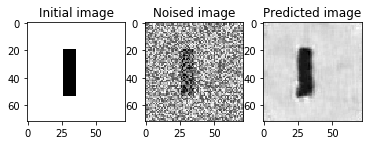

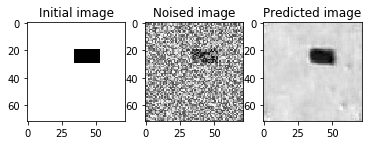

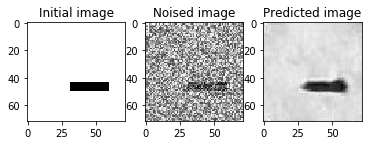

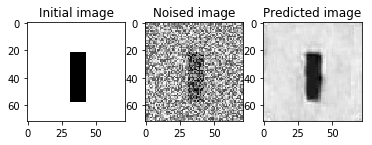

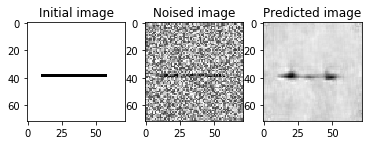

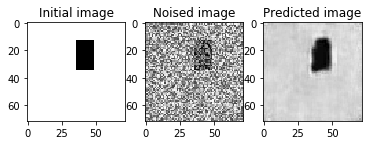

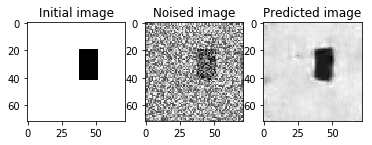

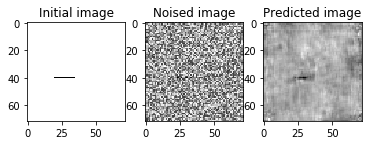

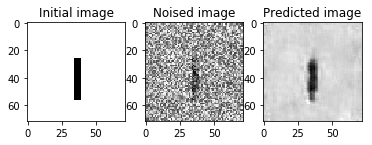

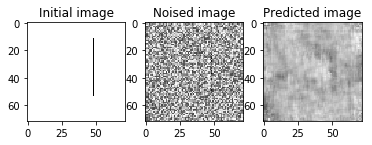

In [166]:
for i in range(10):
    plt.subplot(1, 3, 1)
    plt.imshow(Y_test[i,:,:,0], cmap='gray')
    plt.title("Initial image")
    plt.subplot(1, 3, 2)
    plt.imshow(X_test[i,:,:,0], cmap='gray')
    plt.title('Noised image')
    plt.subplot(1, 3, 3)
    plt.imshow(model.predict(X_test)[i,:,:,0], cmap='gray', label = "predicted")
    plt.title('Predicted image')
    plt.show()

It seems that we are easily able to recreate the original image given the noisy image, which is great. The networks still works when the images are very noisy as can be seen on the above example. However, we see that it gets very hard when our shapes are very thin, because then the noise affects them even more. 

Moreover, we used padding in our network because that way we don't lose information on the borders of the image. 